In [7]:
%matplotlib inline

import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [9]:
# utility function

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    # we assume X and mu are both lists of 1d points, so they have form [[a], [b], [c],...]
    # here we flatten them to 1d arrays, or just lists
    X = X.ravel()
    mu = mu.ravel()
    
    # diagonal of the covariance matrix is the variance at each point
    # square root of variance is standard deviation (how much it deviates at each point)
    # +/- 1.96 standard deviations from the mean covers roughly 95% of the area under a normal curve
    # so if we multiply stdev by 1.96 we get 95% confidence interval
    # which is to say that real value lies in this interval with 95% confidence/probability
    confidence_margin = 1.96 * np.sqrt(np.diag(cov))
    
    # plot confidence intervals at each point of X
    plt.fill_between(X, mu + confidence_margin, mu - confidence_margin, alpha=0.1)
    # plot mean
    plt.plot(X, mu, label='Mean')
    
    # if we've been given samples, plot them too
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    
    # if we've been given training data, plot that too
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')

    plt.legend()

In [2]:
def rbf_kernel(X1, X2, l=1.0, sigma=1.0):
    """
    Isotropic squared exponential kernel.

    Complete formula:
        k(x_i, x_j) = sigma^2 * (- 1 / (2 * l) * (x_i - x_j)^T * (x_i - x_j))
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        l: Lengthscale, constrols the smoothness of the function.
           The kernel is called isotropic because we are using the same l for all dimensions.
        sigma: Controls the vertical variation.

    Returns:
        (m x n) matrix.
    """

    # The part that multiplies Xs can be simplified to the matrix form used in the implementation below
    # (with pen, paper and some experimenting with numpy).
    x1_x2_part = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2*np.dot(X1, X2.T)
    return sigma**2 * np.exp(-1.0/(2 * l**2) * x1_x2_part)


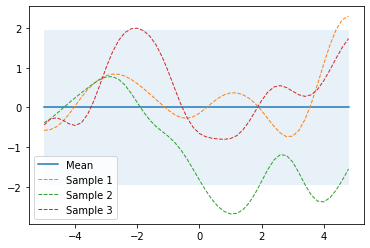

In [5]:
###############################
# here we show GP prior
# to do that we use zero mean and covariance function
# and generate some samples from the prior

# first we just pick some 1d points
X = np.arange(-5, 5, .2).reshape(-1, 1)

# calculate mean and covariance
mean = np.zeros(X.shape)
covariance = rbf_kernel(X, X)

# mean and covariance matrix define a multivariate normal distribution
# we draw some samples from it
samples = np.random.multivariate_normal(mean.ravel(), covariance, 3)

plot_gp(mean, covariance, X, samples=samples)

In [44]:
def posterior(X_s, X_train, Y_train, l=1.0, sigma=1.0, sigma_noise=1e-8):
    """
    Computes the mean and the variance of the posterior distribution at given points X_s.
    
    We are given the training data, and assume some noise `eps` (default is approx zero)
    
    Posterior distribution is given by these formulas (capital_sigma_s is the covariance matrix):
        p(y_s | X_s, X_train, y_train) = N(y_s | mu_s, capital_sigma_s + eps * I)
        where 
        mu_s = (K_s)^T * K^-1 * y_train
        capital_sigma_s = (K_ss) - (K_s)^T * K^-1 * K_s
        
        here
        covariance between training points
        K = kernel(X_train, X_train) + eps * I
        
        covariance between training and new points
        K_s = kernel(X_train, X_s)
        
        # covariance between new points
        K_ss = kernel(X_s, X_s)
        
        We add noise in first kernel to the training inputs.
        Similarly, we add same noise to final covariance to allow noise in observed outputs
    
    
    Essentially what happens here is that we are given some possibly noisy observations.
    We use some math to calculate how new mean and covariance look like, given these observations.
    And we output these new statistics.
    Now we have an updated multivariate normal distribution, and samples from it shall look more like modelled function
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel lengthscale parameter.
        sigma: Kernel vertical variation parameter.
        simga_noise: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    
    # np.eye here is an identity matrix
    K = rbf_kernel(X_train, X_train, l, sigma) + sigma_noise**2 * np.eye(len(X_train))
    K_s = rbf_kernel(X_train, X_s, l, sigma)
    K_ss = rbf_kernel(X_s, X_s, l, sigma)
    K_inv = inv(K)
    
    mu_s = (K_s.T).dot(K_inv).dot(y_train)
    capital_sigma_s = K_ss - (K_s.T).dot(K_inv).dot(K_s)
    capital_sigma_s = capital_sigma_s + sigma_noise**2 * np.eye(capital_sigma_s.shape[0])
    
    return mu_s, capital_sigma_s

/mnt/d/Projects/python-ml-learn/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


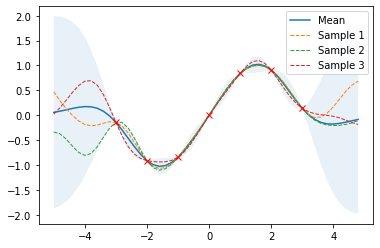

In [53]:
# let's model some function and do noiseless predictions on the same X as before

f = np.sin

# this could be written in a form of [[], [], []]
# but with reshape it's easier to modify
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
y_train = f(X_train).ravel()

# we use same X as before, and pass training data to calculate posterior
mu_s, cov_s = posterior(X, X_train, y_train)

# again, draw some samples from posterior distribution
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

plot_gp(mu_s, cov_s, X, X_train, y_train, samples=samples)

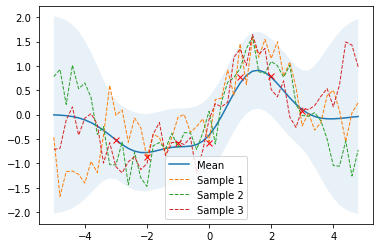

In [56]:
# now let's add some noise

noise = 0.3

# let's model some function and do noiseless predictions on the same X as before

f = np.sin

# this could be written in a form of [[], [], []]
# but with reshape it's easier to modify
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
y_train = f(X_train).ravel()
y_train = y_train + noise * np.random.randn(*y_train.shape)

# we use same X as before, and pass training data to calculate posterior
mu_s, cov_s = posterior(X, X_train, y_train, sigma_noise=noise)

# again, draw some samples from posterior distribution
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

plot_gp(mu_s, cov_s, X, X_train, y_train, samples=samples)

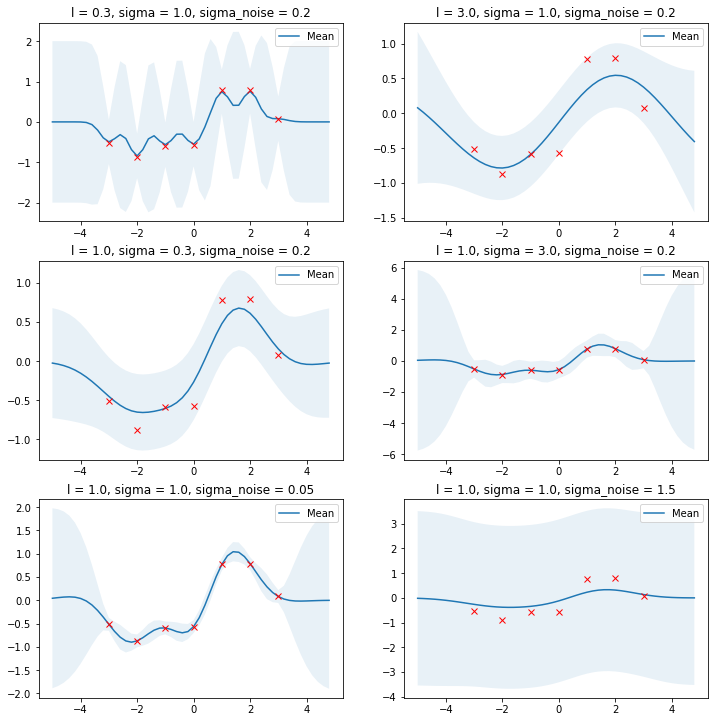

In [57]:
# now let's explore different values of sigma and l in the RBF kernel, as well as noise

params = [
    # l, sigma, noise
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma, sigma_noise) in enumerate(params):
    mu_s, cov_s = posterior(X, X_train, y_train,
                            l=l, 
                            sigma=sigma, 
                            sigma_noise=sigma_noise)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma = {sigma}, sigma_noise = {sigma_noise}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=y_train)

In [17]:
y_train

array([ 0.95892427,  0.7568025 , -0.14112001, -0.90929743, -0.84147098])